In [ ]:
! pip install langchain-anthropic langgraph

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

## Lesson 5: Email Assistant with Semantic + Episodic + Procedural Memory

We previously built an email assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Uses human-in-the-loop to refine the assistant's ability to classify emails
- Drafts responses
- Schedules meetings
- Uses memory to remember details from previous emails 

Now, we'll add procedural memory that allows the user to update instructions for using the calendar and email writing tools. 

In [ ]:
%%capture stderr
%pip install -e ..
%pip install -U -q langchain-anthropic langgraph langchain langmem==0.0.5rc9

In [1]:
import os
from getpass import getpass

if not os.environ.get("ANTHROPIC_API_KEY"):
    os.environ["ANTHROPIC_API_KEY"] = getpass("ANTHROPIC_API_KEY: ")

### Define Triage

The triage step is the "first line of defense" against incoming emails. 

It helps the assistant determine if the email should be responded to, ignored, or notified.

In [2]:
from memory_course.schemas import Router
from langchain.chat_models import init_chat_model
from memory_course.prompts import triage_system_prompt, triage_user_prompt

llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")

# We'll use structured output to generate classification results
llm_router = llm.with_structured_output(Router)


### Define Tools

Define tools that the agent can use. These are place-holder tools for the purpose of testing the LLM.

In [3]:
from langchain_core.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"


@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"


@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

### Define Store

We'll use this to store memories. 

In [4]:
# Example user profile
example_user_profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
}

In [5]:
from langgraph.store.memory import InMemoryStore

# Memory store
store = InMemoryStore()

# Save user profile
user = "lance"
namespace = ("email_assistant", user, "user_profile")
key = "user_profile"
store.put(namespace, key, example_user_profile)

# Example instructions
instructions = """
If updating the user profile, do not omit past information. Simply it with new information from the email that that fits within the profile schema.
"""

# Save instructions
user = "lance"
namespace = ("email_assistant", user, "instructions")
key = "user_instructions"
store.put(namespace, key, instructions)

## Define agent

In [13]:
%load_ext autoreload
%autoreload 2

# Create agent
from memory_course.prompts import agent_system_prompt_memory
from langmem import create_manage_memory_tool, create_search_memory_tool
from langgraph.prebuilt import create_react_agent

# TODO: Hand system prompt updates as shown here:
# https://langchain-ai.github.io/langmem/hot_path_quickstart/#agent

# Get profile
namespace = ("email_assistant", user, "user_profile")
key = "user_profile"
profile = store.get(namespace, key)

# Format profile
profile_data = profile.value
format_data = {
    **profile_data, # Include all individual fields (name, full_name, etc)
    'profile': str(profile_data) # Add the full profile as a string
}

# TODO: We create a node directly from response_agent
# But, we need response_agent to get information from the store
# Specifically, we need the profile and the instructions
# IIUC those will not get properly pulled into the node we create from response_agent?

# Get instructions
namespace = ("email_assistant", user, "instructions")
key = "user_instructions"
instructions = store.get(namespace, key)

# Create agent
response_agent = create_react_agent(
    "anthropic:claude-3-5-sonnet-latest",
    tools=[write_email, schedule_meeting, 
           check_calendar_availability, 
           # TODO: From below, it looks like these will all call "manage_memory" 
           # But, we need to call "manage_memory" with the namespace and key for each tool
           # I'm not sure based on tool calling below that namespace is included?
           create_manage_memory_tool(namespace=("email_assistant", user, "collection")),
           create_manage_memory_tool(namespace=("email_assistant", user, "user_profile")),
           create_search_memory_tool(namespace=("email_assistant", user, "collection")),
           create_manage_memory_tool(namespace=("email_assistant", user, "instructions")),
           ],
    prompt=agent_system_prompt_memory.format(**format_data, instructions=instructions.value),
    store=store
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Build agent + triage workflow

Combine triage with tool calling agent



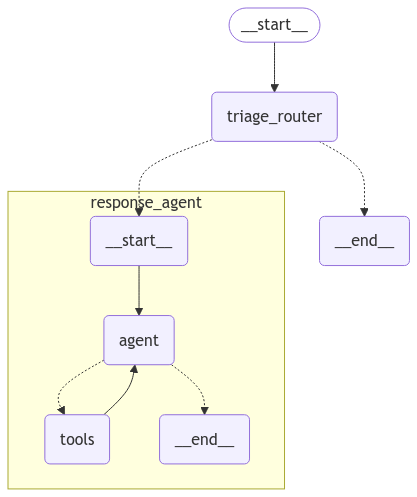

In [23]:
import uuid
from typing import Literal
from IPython.display import Image, display

from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.store.base import BaseStore
from langgraph.types import interrupt, Command

from memory_course.schemas import State
from memory_course.utils import parse_email, format_few_shot_examples

def triage_router(state: State, store: BaseStore, config: RunnableConfig) -> Command[Literal["response_agent", "__end__"]]:
    """Analyze email content and route it based on classification with human feedback.

    The triage step prevents the assistant from wasting time on:
    - Marketing emails and spam
    - Company-wide announcements  
    - Messages meant for other teams

    Args:
        state (State): Current state object containing email_input
        store (BaseStore): Memory store containing user profile and examples
        config (RunnableConfig): Configuration containing user info

    Returns:
        Command: Routing command with either:
            - goto="response_agent" and update with messages for emails needing response
            - goto="__end__" for emails to ignore or notify about

    The function:
    1. Parses the email and retrieves user profile
    2. Uses LLM to classify email as respond/ignore/notify
    3. Gets human feedback on classification
    4. Saves examples when human feedback differs from LLM
    5. Routes email based on final classification"""
   
    print("--Triage Email--")

    # TODO: This just checks if messages are passed w/o an email
    # This is a simple way to handle feedback, but wen can consider other options
    if "messages" in state and not state.get("email_input"):
        return Command(goto="response_agent", update=None)
    
    # Parse email
    author, to, subject, email_thread = parse_email(state["email_input"])
    
    # Get profile from store
    user = config["configurable"]["user"]
    namespace = ("email_assistant", user, "user_profile")
    key = "user_profile"
    profile = store.get(namespace, key)
    profile_data = profile.value

    # Set examples
    namespace = ("email_assistant", user, "examples")
    examples = store.search(namespace) # TODO: Format these 

    author, to, subject, email_thread = parse_email(state["email_input"])
    system_prompt = triage_system_prompt.format(
        full_name=profile_data["full_name"],
        name=profile_data["name"],
        user_profile_background=profile_data["user_profile_background"],
        triage_no=profile_data["triage_rules"]["ignore"],
        triage_notify=profile_data["triage_rules"]["notify"],
        triage_email=profile_data["triage_rules"]["respond"],
        examples=format_few_shot_examples(examples),
    )

    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    # Get triage decision
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    routing_decision = result.classification

    # Get human feedback
    human_feedback = interrupt(
        # Any JSON serializable value to surface to the human.
        # For example, a question or a piece of text or a set of keys in the state
       {
          "Triage for review (update to respond, ignore, notify)": routing_decision
       }
    )

    # Check if human feedback is different from routing decision
    if human_feedback != routing_decision:

        # Save example
        print("--Save Example--")
        user = config["configurable"]["user"]
        namespace = ("email_assistant", user, "examples")
        key = f"example_{uuid.uuid4()}"
        example = f"""Email: {state['email_input']}
            Original routing: {routing_decision}
            Correct routing: {human_feedback}"""
        store.put(namespace, key, example)

        # Set routing decision to correct value
        routing_decision = human_feedback

    # Route
    goto = "__end__"
    update = None
    if routing_decision == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ],
        }
    elif routing_decision == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
    elif routing_decision == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information")
    else:
        raise ValueError(f"Invalid classification: {routing_decision}")
    return Command(goto=goto, update=update)

# Checkpointer
memory = MemorySaver()

# Build workflow with store and checkpointer, as defined above
agent = (
    StateGraph(State)
    .add_node(triage_router)
    .add_node("response_agent", response_agent)
    .add_edge(START, "triage_router")
    .compile(store=store, checkpointer=memory)
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [24]:
import uuid 

# Test email input
email_input = {
    "author": "Sarah Chen <sarah.chen@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Update: Backend API Changes Deployed to Staging",
    "email_thread": """Hi John,

Just wanted to let you know that I've deployed the new authentication endpoints we discussed to the staging environment. Key changes include:

- Implemented JWT refresh token rotation
- Added rate limiting for login attempts
- Updated API documentation with new endpoints

All tests are passing and the changes are ready for review. You can test it out at staging-api.company.com/auth/*

No immediate action needed from your side - just keeping you in the loop since this affects the systems you're working on.

Best regards,
Sarah
""",
}

# Create thread
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id, "user": "lance"}}

# Run the graph with feedback
updated_instructions = """
When writing emails:
1. Always use a professional tone
2. Keep responses concise and to the point
3. Include a clear call to action if needed
4. Sign off with the user's name
5. For technical updates, include a brief summary at the top"""
response = agent.invoke({"messages": {"role": "user", "content": updated_instructions}},config)

--Triage Email--


In [25]:
state = agent.get_state(config)
for m in state.values.get("messages"):
    m.pretty_print()

================================ Human Message =================================


When writing emails:
1. Always use a professional tone
2. Keep responses concise and to the point
3. Include a clear call to action if needed
4. Sign off with the user's name
5. For technical updates, include a brief summary at the top
================================== Ai Message ==================================

[{'text': "I'll help store these important email writing guidelines in memory so they can be consistently applied when composing emails for you. Let me save these instructions.", 'type': 'text'}, {'id': 'toolu_01Y228hGbQjDy8hYZymXkjGv', 'input': {'action': 'create', 'content': "Email Writing Guidelines:\n1. Always maintain a professional tone\n2. Keep responses concise and to the point\n3. Include a clear call to action when needed\n4. Sign off with 'John'\n5. For technical updates, include a brief summary at the top"}, 'name': 'manage_memory', 'type': 'tool_use'}]
Tool Calls:
  manage_memory

In [26]:
# TODO: The instructions that we passed are not updated in the store
namespace = ("email_assistant", user, "instructions")
key = "user_instructions"
instructions = store.get(namespace, key)
instructions

Item(namespace=['email_assistant', 'lance', 'instructions'], key='user_instructions', value="\nUse these tools when appropriate to help manage {name}'s tasks efficiently.\nIf updating the user profile, do not omit past information. Simply it with new information from the email that that fits within the profile schema.\n", created_at='2025-02-06T23:35:04.545060+00:00', updated_at='2025-02-06T23:35:04.545063+00:00')